<a href="https://colab.research.google.com/github/mahata-lab/Tungsten-Ductile-Brittle-Temperature/blob/main/Ductility_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Loading and Analysis

In [1]:
!wget https://raw.githubusercontent.com/mahata-lab/Tungsten-Ductile-Brittle-Temperature/main/Created_Datasets/RT_W_with_ROM.csv

--2025-11-18 21:02:32--  https://raw.githubusercontent.com/mahata-lab/Tungsten-Ductile-Brittle-Temperature/main/Created_Datasets/RT_W_with_ROM.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-11-18 21:02:33 ERROR 404: Not Found.



In [1]:
import pandas as pd

data = pd.read_csv('/content/RT_W_with_ROM.csv')
data.drop(columns = ['composition','elements'],inplace=True)

# columns that won't be used (duplicate or otherwise)
data.drop(columns = ['allen pairwise mismatch','bulk modulus R_AVG','youngs modulus R_AVG','poissons ratio R_AVG','shear modulus R_AVG'], inplace=True)

# make sure only not nans
data = data[data.loc[:,'is_ductile'].notna()]
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68 entries, 0 to 84
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0.1                68 non-null     int64  
 1   Unnamed: 0                  68 non-null     int64  
 2   phases                      27 non-null     object 
 3   hardness (HV)               22 non-null     float64
 4   temperature (C)             68 non-null     int64  
 5   compressive ys (MPa)        39 non-null     float64
 6   compressive strength (MPa)  39 non-null     float64
 7   compressive strain (%)      55 non-null     float64
 8   doi                         68 non-null     object 
 9   ys (MPa)                    12 non-null     float64
 10  uts (MPa)                   13 non-null     float64
 11  elongation (%)              13 non-null     float64
 12  pmg_comp                    68 non-null     object 
 13  is_ductile                  68 non-null   

## Dataset Analysis

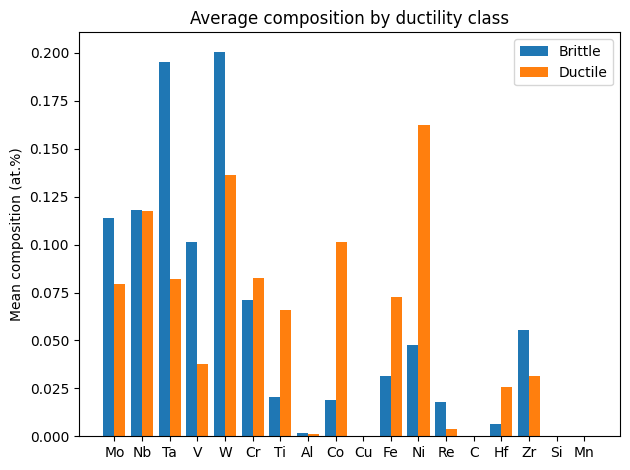

In [2]:
import matplotlib.pyplot as plt
import numpy as np

cols = data.columns[14:32]
means = data.groupby("is_ductile")[cols].mean().T  # transpose for plotting

x = np.arange(len(cols))
width = 0.4

plt.bar(x - width/2, means[False], width, label="Brittle")
plt.bar(x + width/2, means[True], width, label="Ductile")

plt.xticks(x, cols)
plt.ylabel("Mean composition (at.%)")
plt.title("Average composition by ductility class")
plt.legend()
plt.tight_layout()
plt.show()


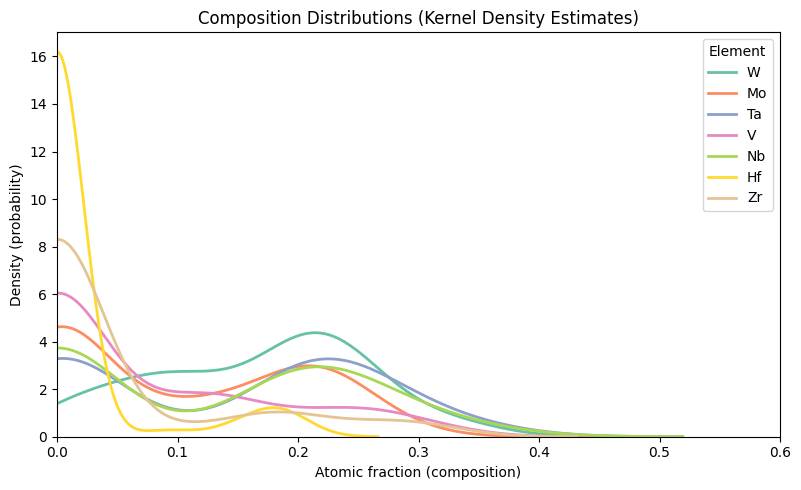

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

els = ["W", "Mo", "Ta", "V", "Nb",'Hf','Zr']
plt.figure(figsize=(8, 5))
for elem, color in zip(els,
                       sns.color_palette("Set2", len(els))):
    sns.kdeplot(
        data=data,
        x=elem,
        fill=False,
        clip=(0, 1),         # <-- restrict KDE domain
        label=elem,
        color=color,
        linewidth=2
    )

plt.legend(title="Element")
plt.xlabel("Atomic fraction (composition)")
plt.ylabel("Density (probability)")
plt.title("Composition Distributions (Kernel Density Estimates)")
plt.tight_layout()
plt.xlim(0, 0.6)
plt.show()


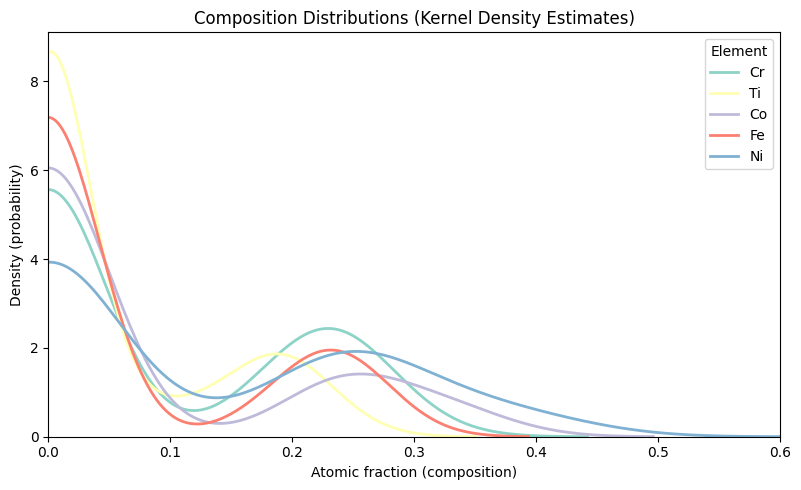

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

els = ["Cr", "Ti", "Co", "Fe","Ni"]
plt.figure(figsize=(8, 5))
for elem, color in zip(els,
                       sns.color_palette("Set3", len(els))):
    sns.kdeplot(
        data=data,
        x=elem,
        fill=False,
        clip=(0, 1),         # <-- restrict KDE domain
        label=elem,
        color=color,
        linewidth=2
    )

plt.legend(title="Element")
plt.xlabel("Atomic fraction (composition)")
plt.ylabel("Density (probability)")
plt.title("Composition Distributions (Kernel Density Estimates)")
plt.tight_layout()
plt.xlim(0, 0.6)
plt.show()

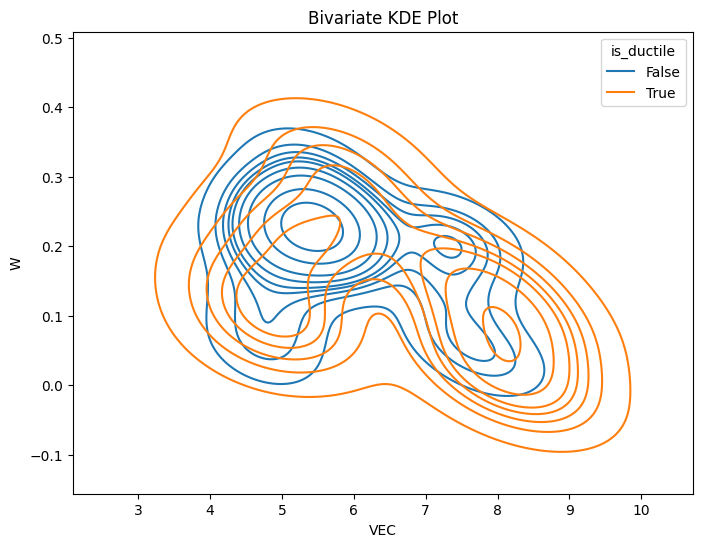

In [5]:
# Bivariate KDE plot of total_bill and tip, colored by time
plt.figure(figsize=(8, 6))
sns.kdeplot(data=data, x="VEC", y="W", hue='is_ductile', fill=False)
plt.title("Bivariate KDE Plot")
plt.show()


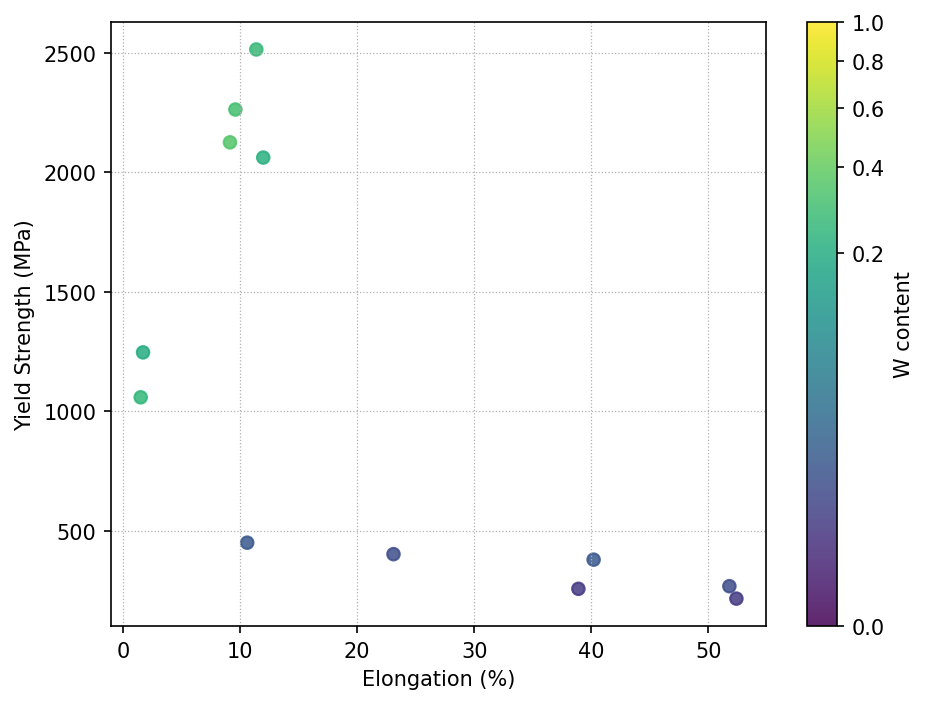

In [6]:
# DataFrame is ys_el with columns: 'ys', 'elongation', 'W'
from matplotlib.colors import PowerNorm

plt.figure(dpi=150)

norm = PowerNorm(gamma=0.3, vmin=0, vmax=max(1, data["W"].max()))  # gamma<1 => more detail near 0


sc = plt.scatter(data["elongation (%)"], data["ys (MPa)"], c=data["W"], norm=norm, s=36, alpha=0.85)
cbar = plt.colorbar(sc)
cbar.set_label("W content")

plt.xlabel("Elongation (%)")
plt.ylabel("Yield Strength (MPa)")
plt.grid(True, linestyle=":", linewidth=0.6)
plt.tight_layout()
plt.show()

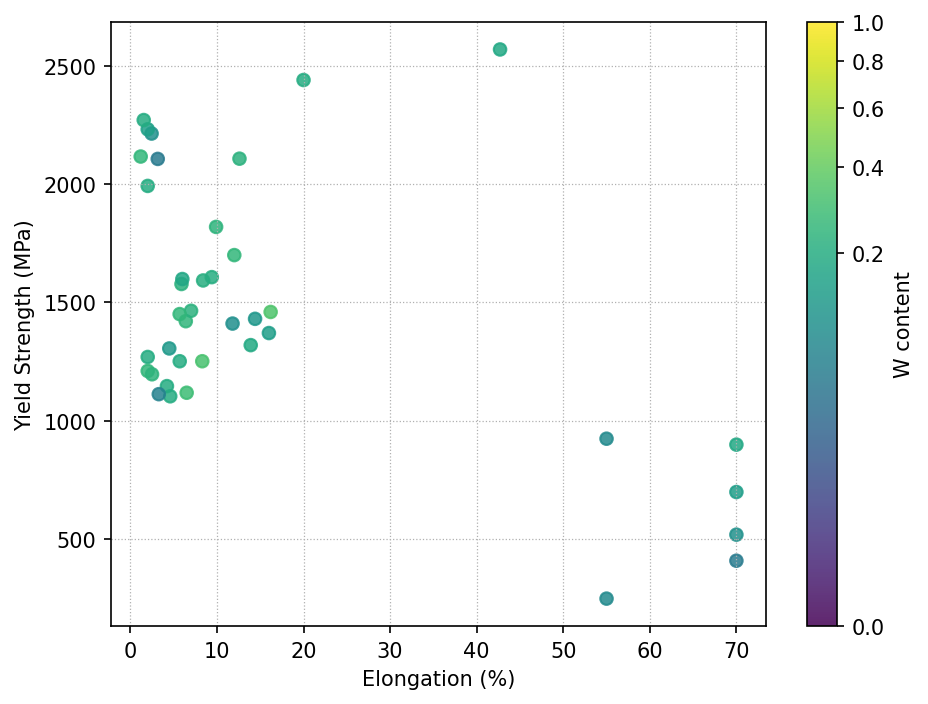

In [7]:
# DataFrame is ys_el with columns: 'ys', 'elongation', 'W'
from matplotlib.colors import PowerNorm

plt.figure(dpi=150)

norm = PowerNorm(gamma=0.3, vmin=0, vmax=max(1, data["W"].max()))  # gamma<1 => more detail near 0


sc = plt.scatter(data["compressive strain (%)"], data["compressive strength (MPa)"], c=data["W"], norm=norm, s=36, alpha=0.85)
cbar = plt.colorbar(sc)
cbar.set_label("W content")

plt.xlabel("Elongation (%)")
plt.ylabel("Yield Strength (MPa)")
plt.grid(True, linestyle=":", linewidth=0.6)
plt.tight_layout()
plt.show()

## Creating Dataset

X = features, y = target (binary ductility class)

In [8]:
# ROM features
X = data.iloc[:,32:47]
# binary ductility classification
y = data.loc[:,'is_ductile'].astype(bool)

In [9]:
y.value_counts()

,count
is_ductile,
True,37
False,31


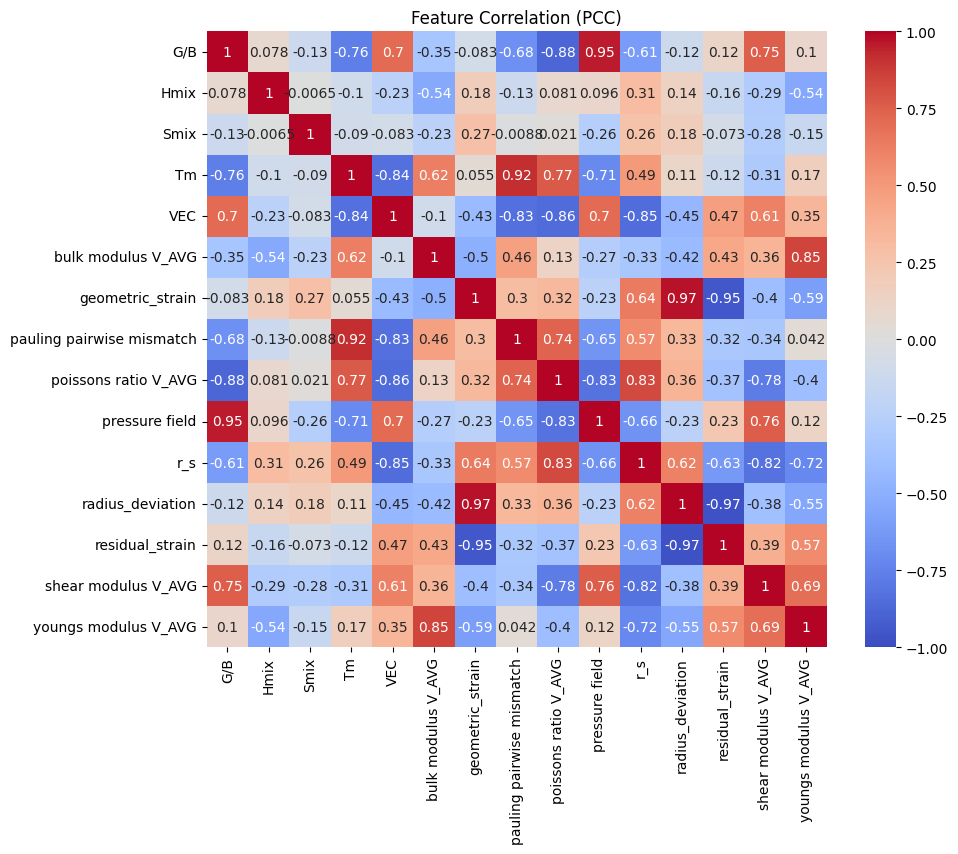

In [10]:
# look at correlation of features to reduce data size

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

corr = X.corr(method='pearson')
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation (PCC)')
plt.show()

In [11]:
import numpy as np

def find_correlated_features(df, threshold=0.9):
    """
    Return a list of (feature_1, feature_2, correlation) tuples
    where |corr| > threshold.
    """
    corr = df.corr().abs()
    Ucorr = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

    corr_pairs = []
    for idx, row in Ucorr.iterrows():
        for col, val in row.items():
            if pd.notna(val) and val > threshold:
                corr_pairs.append((idx, col, val))

    return corr_pairs

find_correlated_features(X,threshold=0.85)


[('G/B', 'poissons ratio V_AVG', 0.8795841453378077),
 ('G/B', 'pressure field', 0.9541760448985596),
 ('Tm', 'pauling pairwise mismatch', 0.9201363268204404),
 ('VEC', 'poissons ratio V_AVG', 0.855540661495219),
 ('bulk modulus V_AVG', 'youngs modulus V_AVG', 0.851035568789578),
 ('geometric_strain', 'radius_deviation', 0.9737671415616794),
 ('geometric_strain', 'residual_strain', 0.9475916350980687),
 ('radius_deviation', 'residual_strain', 0.9749726875137703)]

In [12]:
# choose what columns to drop based on validity of the rom calculation (interpretability and generality)
corr_col_drop = ['Tm','poissons ratio V_AVG','youngs modulus V_AVG',
                 'geometric_strain','residual_strain','pressure field']

In [13]:
# set training set to uncorrelated values
X = X.drop(columns=corr_col_drop)


# Classification Models

## Model Selection

training, validation, metrics

### Random Forest Classification

In [56]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, balanced_accuracy_score
from sklearn.base import clone

# Define the base random forest
rf = RandomForestClassifier(
    criterion='gini',
    max_features='sqrt',
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    random_state=42,
    class_weight='balanced'
)

# Define parameter grid
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [2, 3, 5, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 3]
}

# Define multiple scorers
scorers = {
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'precision': make_scorer(precision_score, average='binary', zero_division=0),
    'recall': make_scorer(recall_score, average='binary', zero_division=0),
    'f1': make_scorer(f1_score, average='binary', zero_division=0)
}

# Define CV splits
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Setup GridSearchCV - use one metric for hyperparameter selection
rf_grid_search = GridSearchCV(
    rf,
    rf_params,
    cv=inner_cv,  # Inner CV
    scoring='balanced_accuracy',  # Metric used to select best hyperparameters
    n_jobs=-1,
    verbose=1,
    refit=True
)

# NESTED CV: Evaluate all metrics efficiently
print("Running nested CV with multiple metrics...")

# Single pass through outer folds
fold_predictions = []
fold_true_labels = []

for train_idx, test_idx in outer_cv.split(X, y):
    X_train = X.iloc[train_idx] if hasattr(X, 'iloc') else X[train_idx]
    X_test = X.iloc[test_idx] if hasattr(X, 'iloc') else X[test_idx]
    y_train = y.iloc[train_idx] if hasattr(y, 'iloc') else y[train_idx]
    y_test = y.iloc[test_idx] if hasattr(y, 'iloc') else y[test_idx]

    grid_clone = clone(rf_grid_search)
    grid_clone.fit(X_train, y_train)
    y_pred = grid_clone.predict(X_test)

    fold_predictions.append(y_pred)
    fold_true_labels.append(y_test)

# Compute all metrics from fold predictions
rf_results = {metric: [] for metric in scorers.keys()}

for y_true, y_pred in zip(fold_true_labels, fold_predictions):
    for metric_name, scorer in scorers.items():
        score = scorer._score_func(y_true, y_pred)
        rf_results[metric_name].append(score)

# Convert to mean and std format
rf_results = {
    metric: {'mean': np.mean(scores), 'std': np.std(scores)}
    for metric, scores in rf_results.items()
}

# Display all results
print("\n=== Random Forest Nested CV Results ===")
for metric_name, result in rf_results.items():
    print(f"{metric_name.replace('_', ' ').title()}: {result['mean']:.4f} (+/- {result['std']:.4f})")

# Fit on all data to get best hyperparameters and final model
rf_grid_search.fit(X, y)
best_rf = rf_grid_search.best_estimator_
print("\nBest parameters:", rf_grid_search.best_params_)

Running nested CV with multiple metrics...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits

=== Random Forest Nested CV Results ===
Balanced Accuracy: 0.7792 (+/- 0.1749)
Precision: 0.8100 (+/- 0.1855)
Recall: 0.7833 (+/- 0.2179)
F1: 0.7856 (+/- 0.1787)
Fitting 5 folds for each of 32 candidates, totalling 160 fits

Best parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


#### INSPECTION

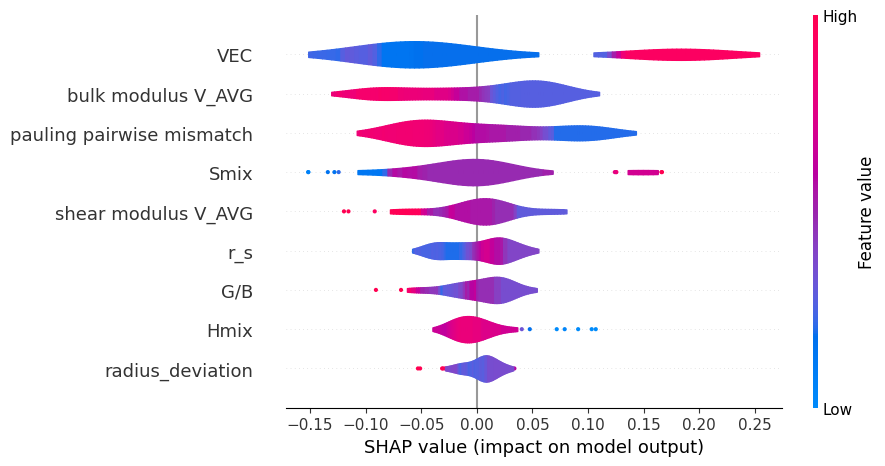

In [74]:
import shap

best_rf = rf_grid_search.best_estimator_

explainer = shap.TreeExplainer(best_rf)
ex = explainer(X)                      # ex.values: (n_samples, n_features, n_classes)

# pick class 1 (positive class)
shap.plots.violin(ex[:, :, 1])         # 2-D slice: (n_samples, n_features)


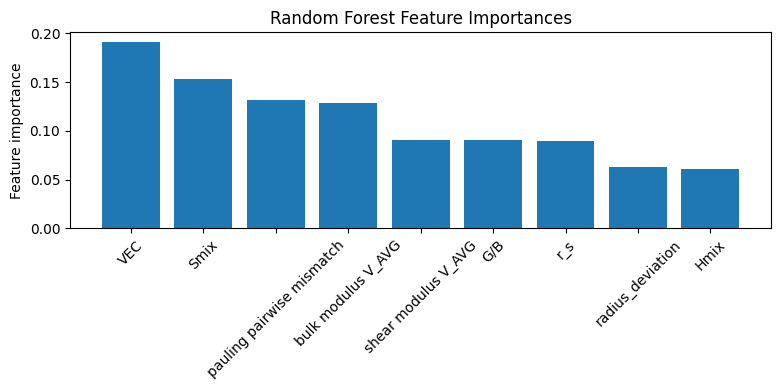

In [75]:
# impurity-based feature importance
import numpy as np

importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8,4))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), np.array(X.columns)[indices], rotation=45)
plt.ylabel("Feature importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

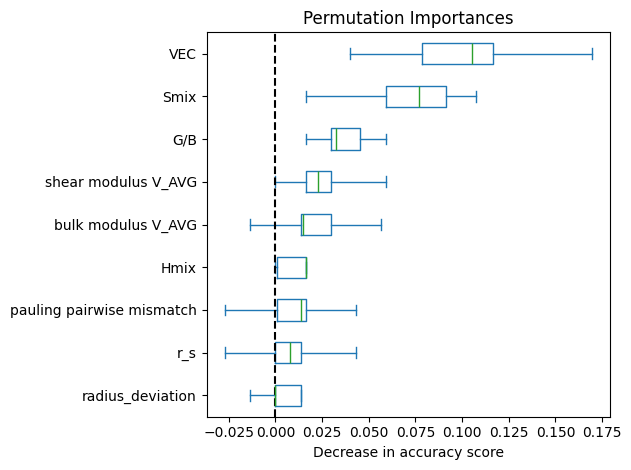

In [76]:
# permutation importance (how much the estimators rely on a feature to get correct classification)
# permutations may give a better idea of importance/weight since many of the features 'share importance'
# https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

from sklearn.inspection import permutation_importance

result = permutation_importance(best_rf, X, y, scoring='balanced_accuracy', n_repeats=30)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)

ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()


In [ ]:
import numpy as np
from sklearn.model_selection import ShuffleSplit
from sklearn.inspection import permutation_importance

splits = ShuffleSplit(n_splits=20, test_size=0.2, random_state=0)
importances = []

for train_idx, test_idx in splits.split(X):
    rf.fit(X.iloc[train_idx], y.iloc[train_idx])
    r = permutation_importance(rf, X.iloc[test_idx], y.iloc[test_idx])
    importances.append(r.importances_mean)

np.std(importances, axis=0)   # feature-wise instability


array([0.02605919, 0.01      , 0.05787037, 0.08068584, 0.05935022,
       0.05801126, 0.05373309, 0.0324509 , 0.05333758])

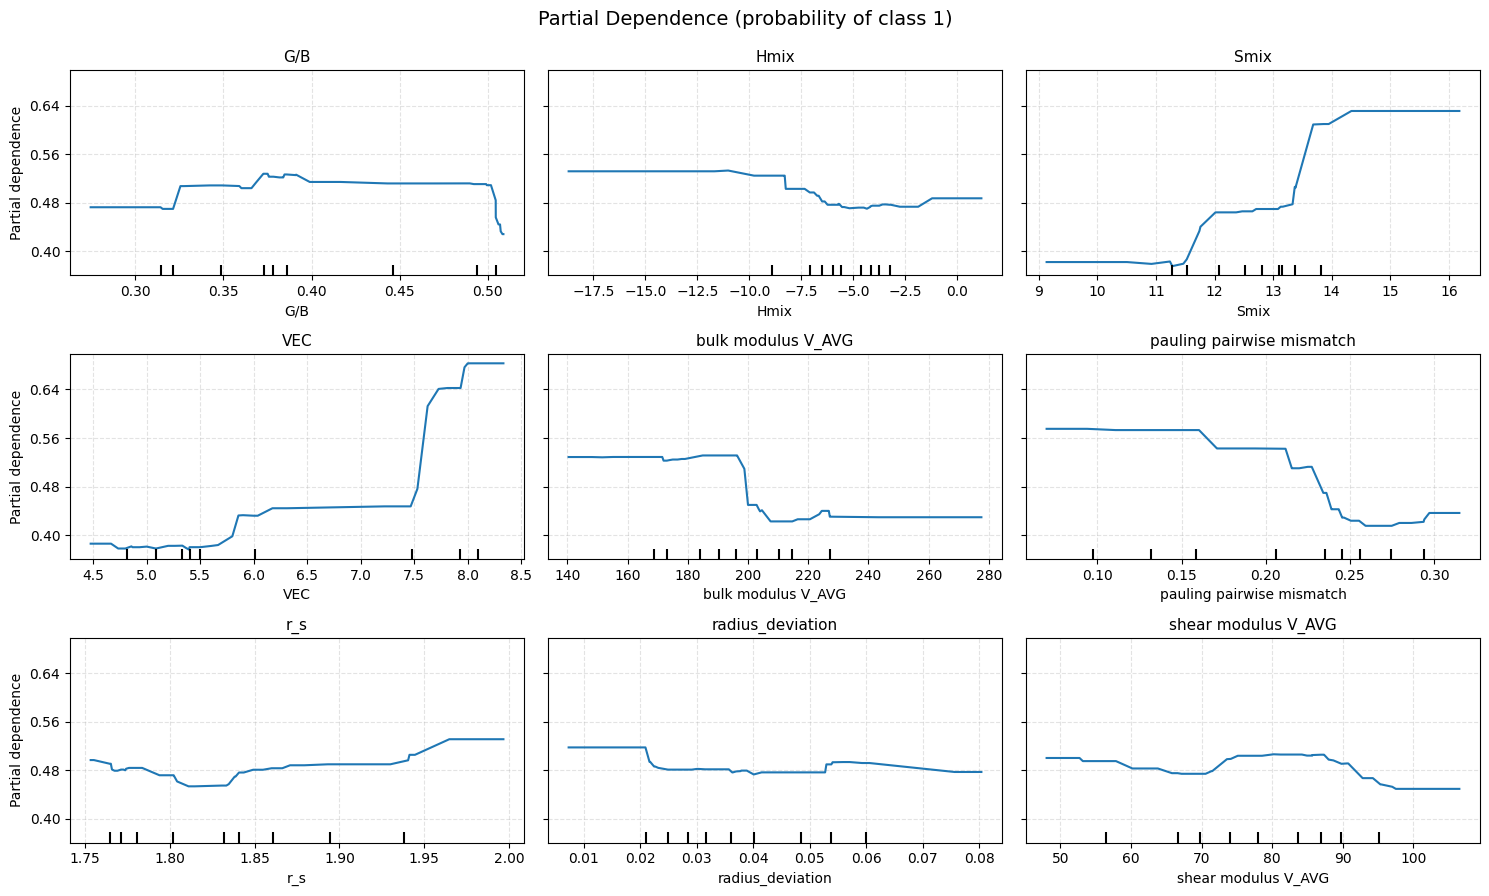

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from sklearn.inspection import PartialDependenceDisplay

feats = list(X.columns)

# dynamically set number of rows and columns
ncols = 3
nrows = int(np.ceil(len(feats) / ncols))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 3*nrows), sharey=True)

disp = PartialDependenceDisplay.from_estimator(
    rf, X, feats,
    ax=ax,
    kind="average",
    grid_resolution=80,
    response_method="predict_proba",
    target=1,
    percentiles=(0.05, 0.95),
)

# format subplots
axes = disp.axes_.ravel()
for i, (a, f) in enumerate(zip(axes, feats)):
    a.set_title(f, fontsize=11)
    a.grid(True, axis='both', linestyle='--', alpha=0.35)
    a.yaxis.set_major_locator(mticker.MaxNLocator(5))
    a.yaxis.set_major_formatter(mticker.FormatStrFormatter("%.2f"))
    if i % ncols != 0:  # remove redundant y-labels except first column
        a.set_ylabel("")

# remove any empty axes if len(feats) not divisible by ncols
for j in range(len(feats), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Partial Dependence (probability of class 1)", y=0.99, fontsize=14)
plt.tight_layout()
plt.show()




### Logistic Regression

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, balanced_accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

lr_params = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1','l2'],
    'classifier__solver': ['liblinear'],
    'classifier__max_iter': [1000],
}

# Create pipeline with scaling
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, class_weight='balanced'))
])

# Define multiple scorers
scorers = {
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'precision': make_scorer(precision_score, average='binary', zero_division=0),
    'recall': make_scorer(recall_score, average='binary', zero_division=0),
    'f1': make_scorer(f1_score, average='binary', zero_division=0)
}

inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Setup GridSearchCV - use one metric for hyperparameter selection
lr_grid_search = GridSearchCV(
    lr_pipeline,
    lr_params,
    cv=inner_cv,  # Inner CV
    scoring='balanced_accuracy',  # Metric used to select best hyperparameters
    n_jobs=-1,
    verbose=1,
    refit=True
)

# NESTED CV: Evaluate all metrics efficiently
print("Running nested CV with multiple metrics...")

# Single pass through outer folds
fold_predictions = []
fold_true_labels = []

for train_idx, test_idx in outer_cv.split(X, y):
    X_train = X.iloc[train_idx] if hasattr(X, 'iloc') else X[train_idx]
    X_test = X.iloc[test_idx] if hasattr(X, 'iloc') else X[test_idx]
    y_train = y.iloc[train_idx] if hasattr(y, 'iloc') else y[train_idx]
    y_test = y.iloc[test_idx] if hasattr(y, 'iloc') else y[test_idx]

    grid_clone = clone(lr_grid_search)
    grid_clone.fit(X_train, y_train)
    y_pred = grid_clone.predict(X_test)

    fold_predictions.append(y_pred)
    fold_true_labels.append(y_test)

# Compute all metrics from fold predictions
lr_results = {metric: [] for metric in scorers.keys()}

for y_true, y_pred in zip(fold_true_labels, fold_predictions):
    for metric_name, scorer in scorers.items():
        score = scorer._score_func(y_true, y_pred)
        lr_results[metric_name].append(score)

# Convert to mean and std format
lr_results = {
    metric: {'mean': np.mean(scores), 'std': np.std(scores)}
    for metric, scores in lr_results.items()
}

# Display all results
print("\n=== Logistic Regression Nested CV Results ===")
for metric_name, result in lr_results.items():
    print(f"{metric_name.replace('_', ' ').title()}: {result['mean']:.4f} (+/- {result['std']:.4f})")

# Fit on all data to get best hyperparameters and final model
lr_grid_search.fit(X, y)
best_lr = lr_grid_search.best_estimator_
print("\nBest parameters:", lr_grid_search.best_params_)

Running nested CV with multiple metrics...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits

=== Logistic Regression Nested CV Results ===
Balanced Accuracy: 0.8417 (+/- 0.1706)
Precision: 0.9050 (+/- 0.1619)
Recall: 0.8083 (+/- 0.2268)
F1: 0.8317 (+/- 0.1763)
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best parameters: {'classifier__C': 10, 'classifier__max_iter': 1000, 'classifier__penalty': 'l1', 'classifier__solve

In [70]:
# Extract the classifier from the pipeline
best_lr = lr_grid_search.best_estimator_
classifier = best_lr.named_steps['classifier']

# Get coefficients from the classifier (not the pipeline)
coefs = classifier.coef_.ravel()

odds = np.exp(coefs)
import pandas as pd
coef_df = pd.DataFrame({
    "feature": getattr(X, "columns", np.arange(len(coefs))),  # Use X, not X_s
    "coef": coefs,
    "odds_ratio": odds
}).sort_values("coef", ascending=False).set_index('feature')

print(coef_df)

                               coef  odds_ratio
feature                                        
r_s                        4.888456  132.748389
VEC                        4.851330  127.910391
shear modulus V_AVG        3.441152   31.222899
Smix                       0.009149    1.009191
pauling pairwise mismatch  0.000000    1.000000
Hmix                      -0.261486    0.769906
radius_deviation          -1.184908    0.305774
bulk modulus V_AVG        -1.938475    0.143923
G/B                       -3.659899    0.025735


#### INSPECTION


Best parameters: {'classifier__C': 10, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}


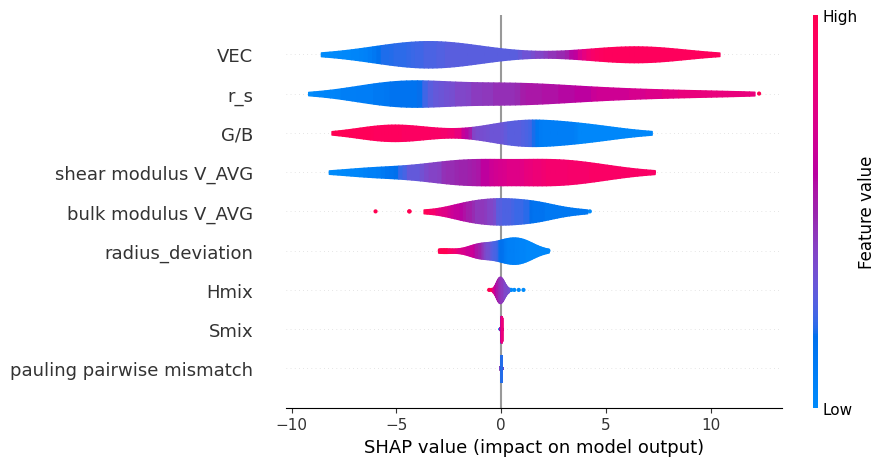

In [68]:
import shap

best_lr = lr_grid_search.best_estimator_


# Extract the scaler and classifier from the pipeline
scaler = best_lr.named_steps['scaler']
classifier = best_lr.named_steps['classifier']

# Scale the data using the fitted scaler
X_scaled = scaler.transform(X)

# Create SHAP explainer with the classifier and scaled data
lr_explainer = shap.Explainer(classifier, X_scaled)
lr_shap_values = lr_explainer(X_scaled)

# Visualize SHAP values
shap.plots.violin(lr_shap_values, X_scaled, feature_names=X.columns if hasattr(X, 'columns') else None)

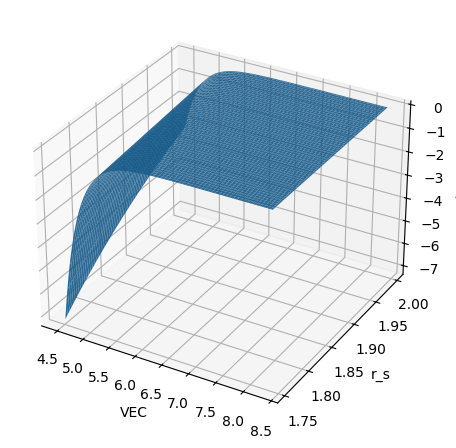

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def plot_3d_surface(clf, X, f1, f2, target=1):
    x1 = X[f1].to_numpy(); x2 = X[f2].to_numpy()
    g1 = np.linspace(x1.min(), x1.max(), 120)
    g2 = np.linspace(x2.min(), x2.max(), 120)
    xx, yy = np.meshgrid(g1, g2)

    ref = X.median(numeric_only=True).to_dict()
    Xref = pd.DataFrame({c: ref.get(c, 0) for c in X.columns}, index=np.arange(xx.size))
    Xref[f1] = xx.ravel(); Xref[f2] = yy.ravel()

    if hasattr(clf, "predict_proba"):
        Z = clf.predict_proba(Xref)[:, target].reshape(xx.shape)
    else:
        Z = 1/(1+np.exp(-clf.decision_function(Xref))).reshape(xx.shape)

    fig = plt.figure(figsize=(6,4.5))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(xx, yy, Z, rstride=2, cstride=2, alpha=0.9)
    ax.set_xlabel(f1); ax.set_ylabel(f2); ax.set_zlabel("P(y=1)")
    plt.tight_layout(); plt.show()

# usage:
plot_3d_surface(lr, X, "VEC", "r_s")

### Support Vector Classification

In [59]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, balanced_accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

svc_params = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__kernel': ['linear', 'rbf', 'poly'],
    'classifier__gamma': ['scale', 'auto']
}

# Create pipeline with scaling (REQUIRED for SVC)
svc_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(random_state=42, class_weight='balanced'))
])

# Define multiple scorers
scorers = {
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'precision': make_scorer(precision_score, average='binary', zero_division=0),
    'recall': make_scorer(recall_score, average='binary', zero_division=0),
    'f1': make_scorer(f1_score, average='binary', zero_division=0)
}

inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Setup GridSearchCV - use one metric for hyperparameter selection
svc_grid_search = GridSearchCV(
    svc_pipeline,
    svc_params,
    cv=inner_cv,  # Inner CV
    scoring='balanced_accuracy',  # Metric used to select best hyperparameters
    n_jobs=-1,
    verbose=1,
    refit=True
)

# NESTED CV: Evaluate all metrics efficiently
print("Running nested CV with multiple metrics...")

# Single pass through outer folds
fold_predictions = []
fold_true_labels = []

for train_idx, test_idx in outer_cv.split(X, y):
    X_train = X.iloc[train_idx] if hasattr(X, 'iloc') else X[train_idx]
    X_test = X.iloc[test_idx] if hasattr(X, 'iloc') else X[test_idx]
    y_train = y.iloc[train_idx] if hasattr(y, 'iloc') else y[train_idx]
    y_test = y.iloc[test_idx] if hasattr(y, 'iloc') else y[test_idx]

    grid_clone = clone(svc_grid_search)
    grid_clone.fit(X_train, y_train)
    y_pred = grid_clone.predict(X_test)

    fold_predictions.append(y_pred)
    fold_true_labels.append(y_test)

# Compute all metrics from fold predictions
svc_results = {metric: [] for metric in scorers.keys()}

for y_true, y_pred in zip(fold_true_labels, fold_predictions):
    for metric_name, scorer in scorers.items():
        score = scorer._score_func(y_true, y_pred)
        svc_results[metric_name].append(score)

# Convert to mean and std format
svc_results = {
    metric: {'mean': np.mean(scores), 'std': np.std(scores)}
    for metric, scores in svc_results.items()
}

# Display all results
print("\n=== SVC Nested CV Results ===")
for metric_name, result in svc_results.items():
    print(f"{metric_name.replace('_', ' ').title()}: {result['mean']:.4f} (+/- {result['std']:.4f})")

# Fit on all data to get best hyperparameters and final model
svc_grid_search.fit(X, y)
best_svc = svc_grid_search.best_estimator_
print("\nBest parameters:", svc_grid_search.best_params_)

Running nested CV with multiple metrics...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits

=== SVC Nested CV Results ===
Balanced Accuracy: 0.8375 (+/- 0.1155)
Precision: 0.8967 (+/- 0.1301)
Recall: 0.8333 (+/- 0.2041)
F1: 0.8367 (+/- 0.1341)
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best parameters: {'classifier__C': 10, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}


#### INSPECTION


Best parameters: {'classifier__C': 10, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}


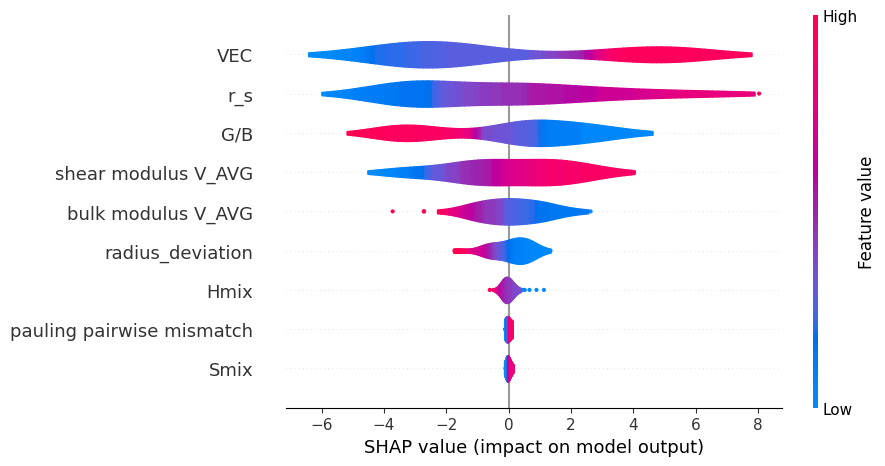

In [67]:
import shap

best_svc = svc_grid_search.best_estimator_
print("\nBest parameters:", svc_grid_search.best_params_)

# Extract the scaler and classifier from the pipeline
scaler = best_svc.named_steps['scaler']
classifier = best_svc.named_steps['classifier']

# Scale the data using the fitted scaler
X_scaled = scaler.transform(X)

# Create SHAP explainer with the classifier and scaled data
svc_explainer = shap.Explainer(classifier, X_scaled)
svc_shap_values = svc_explainer(X_scaled)

# Visualize SHAP values
shap.plots.violin(svc_shap_values, X_scaled, feature_names=X.columns if hasattr(X, 'columns') else None)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NuSVC was fitted with feature names
  warnings.warn(


  0%|          | 0/68 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NuSVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NuSVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NuSVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NuSVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NuSVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does n

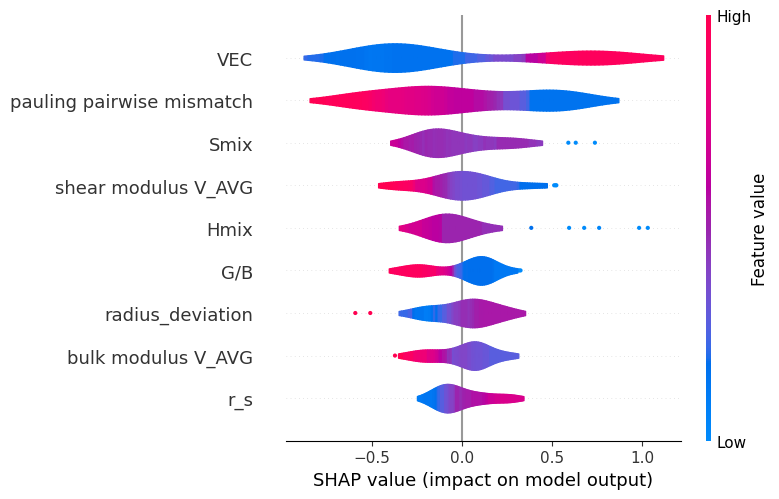

In [ ]:
# X_s = scaler.transform(X)
# KernelExplainer needs a callable: f(X) → probabilities or decision values
f = lambda x: nu_rbf.decision_function(x)
# Sample background for SHAP (20–100 random points is enough)
background = shap.sample(X_s, 100, random_state=0)

# Create the explainer
nusvc_explainer = shap.KernelExplainer(f, background)

nusvc_shap_values = nusvc_explainer.shap_values(X_s)
shap.summary_plot(nusvc_shap_values, X_s, plot_type="violin")


### Combining metrics into a table

In [62]:
for metric_name, result in rf_results.items():
    print(f"{metric_name.replace('_', ' ').title()}: {result['mean']:.4f} (+/- {result['std']:.4f})")


for metric_name, result in lr_results.items():
    print(f"{metric_name.replace('_', ' ').title()}: {result['mean']:.4f} (+/- {result['std']:.4f})")


for metric_name, result in svc_results.items():
    print(f"{metric_name.replace('_', ' ').title()}: {result['mean']:.4f} (+/- {result['std']:.4f})")


Balanced Accuracy: 0.7792 (+/- 0.1749)
Precision: 0.8100 (+/- 0.1855)
Recall: 0.7833 (+/- 0.2179)
F1: 0.7856 (+/- 0.1787)
Balanced Accuracy: 0.8417 (+/- 0.1706)
Precision: 0.9050 (+/- 0.1619)
Recall: 0.8083 (+/- 0.2268)
F1: 0.8317 (+/- 0.1763)
Balanced Accuracy: 0.8375 (+/- 0.1155)
Precision: 0.8967 (+/- 0.1301)
Recall: 0.8333 (+/- 0.2041)
F1: 0.8367 (+/- 0.1341)


In [61]:
# Fit on all data to get best hyperparameters and final model
best_rf = rf_grid_search.best_estimator_
print("\nBest parameters:", rf_grid_search.best_params_)


best_lr = lr_grid_search.best_estimator_
print("\nBest parameters:", lr_grid_search.best_params_)


best_svc = svc_grid_search.best_estimator_
print("\nBest parameters:", svc_grid_search.best_params_)


Best parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Best parameters: {'classifier__C': 10, 'classifier__max_iter': 1000, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}

Best parameters: {'classifier__C': 10, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}


In [ ]:
rf_test_scores

{'Random Forest precision score': np.float64(0.833),
 'Random Forest recall score': np.float64(0.625),
 'Random Forest f1 score': np.float64(0.714),
 'Random Forest balanced accuracy score': np.float64(0.729)}

In [ ]:
nu_rbf_cv

{'RBF SVC CV precision': '0.791 ± 0.127',
 'RBF SVC CV recall': '0.773 ± 0.204',
 'RBF SVC CV F1': '0.755 ± 0.146',
 'RBF SVC CV balanced accuracy': '0.747 ± 0.121'}

In [ ]:
nu_lin_cv

{'Linear SVC CV precision': '0.832 ± 0.119',
 'Linear SVC CV recall': '0.827 ± 0.211',
 'Linear SVC CV F1': '0.811 ± 0.164',
 'Linear SVC CV balanced accuracy': '0.809 ± 0.128'}

In [ ]:
nu_lin_test_scores

{'Linear SVC precision score': np.float64(0.833),
 'Linear SVC recall score': np.float64(0.625),
 'Linear SVC f1 score': np.float64(0.714),
 'Linear SVC balanced accuracy score': np.float64(0.729)}

In [ ]:
lr_cv

{'Random Forest CV precision': '0.789 ± 0.155',
 'Random Forest CV recall': '0.807 ± 0.206',
 'Random Forest CV F1': '0.784 ± 0.169',
 'Random Forest CV balanced accuracy': '0.771 ± 0.143'}

## Final Model

train most balanced model on all of the data, save weights, examine properties

In [ ]:
# best generalizing model and best hyperparams

In [ ]:
clf = randomforest(hyperparams)

# Alloying strategy/visualizing decision boundary

psudo-ternary/latent space/turn forward predictions into mapping of alloy space

distribution of input elements, sample from it, generate ROM,
or distribution of ROM and calculus on input elements

decision surfaces from support vectors/logits as lagrangian constraints

## Getting distributions of new alloys from gaussian noise on existing compositions (normalize to comp sum = 1)

In [ ]:
import numpy as np
import pandas as pd

# noise around existing data

def noisy_compositions(X, noise_scale=0.02, n_samples=5, clip_zero=True, random_state=None):

    rng = np.random.default_rng(random_state)
    X = np.asarray(X, dtype=float)
    n_alloys, n_elems = X.shape

    all_noisy = []
    for i in range(n_alloys):
        # generate noise (Gaussian around 0)
        noise = rng.normal(0, noise_scale, size=(n_samples, n_elems)) + 1
        perturbed = X[i] * noise

        if clip_zero:
            perturbed = np.clip(perturbed, 0, None)

        # renormalize each composition so rows sum to 1
        perturbed /= perturbed.sum(axis=1, keepdims=True)
        all_noisy.append(perturbed)

    return np.vstack(all_noisy)




noisy_X = noisy_compositions(data.iloc[:,14:32], noise_scale=0.2, n_samples=20, random_state=42)
comps = pd.DataFrame(noisy_X, columns=data.iloc[:,14:32].columns)


In [ ]:
# fill out composition space

## ROM calculations on sampled alloys (only features from reduced set)

In [29]:
!wget https://raw.githubusercontent.com/mahata-lab/Tungsten-Ductile-Brittle-Temperature/main/Experimental_Datasets/ROM_dataset.csv
!wget https://raw.githubusercontent.com/mahata-lab/Tungsten-Ductile-Brittle-Temperature/main/Experimental_Datasets/Hmix.csv

--2025-11-18 21:32:09--  https://raw.githubusercontent.com/mahata-lab/Tungsten-Ductile-Brittle-Temperature/main/Experimental_Datasets/ROM_dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-11-18 21:32:10 ERROR 404: Not Found.

--2025-11-18 21:32:10--  https://raw.githubusercontent.com/mahata-lab/Tungsten-Ductile-Brittle-Temperature/main/Experimental_Datasets/Hmix.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-11-18 21:32:11 ERROR 404: Not Found.



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


rom = pd.read_csv('/content/ROM_dataset.csv',index_col=0)
Hmix = pd.read_csv('/content/Hmix.csv',index_col=0)
rom.drop(['Atomic number'], axis=0, inplace=True)
rom.drop(['element'], axis=0, inplace=True)
rom = rom.astype(float)
rom.index

Index(['Bulk Modulus', 'r_s', 'rho', 'Atomic radius (pm)', 'Melting point (K)',
       'Boiling point (K)', 'Pauling electronegativity (-)',
       'Allen electronegativity (-)', 'Valence electron concentration (-)',
       'Itinerant electrons per atom (-)', 'Atomic weight (g/mol)',
       'Density (g/cm3)', 'Molar heat capacity (J/mol K)',
       'Thermal conductivity (W/m/K)', 'shear modulus', 'poissons ratio',
       'youngs modulus', 'bulk modulus'],
      dtype='object')

In [ ]:
def extract_nonzero(row):
    # only elements with nonzero composition
    mask = row != 0

    # extract elements and composition
    els = row.index[mask].to_numpy()
    x = row.values[mask].astype(float)
    return els, x

# get two new columns to use in functions
comps['elements'], comps['composition'] = zip(*comps.apply(extract_nonzero, axis=1))


### Radius mismatch

$
\delta r = \sqrt{\sum_{i=1}^n x_i \left(1 - \frac{r_i}{r}\right)^2}
$







In [ ]:
import numpy as np

def radius_deviation(x, r):
    """
    Atomic size mismatch parameter δ

    x : array of weights (compositions), should sum to 1
    r : array of atomic radii
    """
    x = np.asarray(x)
    r = np.asarray(r)

    rhat = np.dot(x, r)  # weighted mean radius

    # sum of elementwise products
    return np.sqrt(np.sum(x * (1 - r / rhat) ** 2))

els = ['Co','Fe','Ni']
x = np.array([0.333, 0.333, 0.333]).T
r = rom.loc['Atomic radius (pm)',els].values


print(radius_deviation(x,r))



0.003365508315388705


In [ ]:
# apply radius deviation function to each row of comps using lambda row to access multiple values
comps['radius_deviation'] = comps.apply(
    lambda row: radius_deviation(
        row['composition'],
        rom.loc['Atomic radius (pm)', row['elements']].to_numpy()
    ),
    axis=1
)

comps[['elements', 'composition','radius_deviation']].head()

,elements,composition,radius_deviation
0,"[Mo, Nb, Ta, V, W]","[0.22098647568559104, 0.1649682618062168, 0.23...",0.033201
1,"[Mo, Nb, Ta, V, W]","[0.2244945132703785, 0.1890403790635648, 0.183...",0.029827
2,"[Mo, Nb, Ta, V, W]","[0.19849687483780212, 0.16899448624039923, 0.1...",0.031269
3,"[Mo, Nb, Ta, V, W]","[0.18682945497652126, 0.17987927317484848, 0.1...",0.033188
4,"[Mo, Nb, Ta, V, W]","[0.16333057630016962, 0.2200328228636723, 0.20...",0.032816


### Enthalpy/Entropy of Mixing


$
\Delta H^m = \sum_{i=1}^n \sum_{\substack{j=1 \\ j \ne i}}^n 4 \Delta H_{ij}^m x_i x_j
$

is really just a [quadratic form](https://en.wikipedia.org/wiki/Quadratic_form)

$\displaystyle q_{A}(x_{1},\ldots ,x_{n})=\sum _{i=1}^{n}\sum _{j=1}^{n}a_{ij}{x_{i}}{x_{j}}=\mathbf {x} ^{\mathsf {T}}A\mathbf {x}$ when A is symmetric, which it is for pairwise mixing enthalpies. The data we have is upper triangular, so we'll transform it to a symmetric matrix with the same quadratic form.

$\displaystyle B=\left({\frac {a_{ij}+a_{ji}}{2}}\right)={\frac {1}{2}}(A+A^{\text{T}})$

so that
$\Delta H^m = \mathbf {x} ^{\mathsf {T}}B\mathbf {x}$
where x is the composition vector.

Multiplying this by 4 gives the correct Hmix according to the Miedema model


In [ ]:
Hmix = pd.read_csv('/content/Hmix.csv',index_col=0)

def alloy_Hmix(els, x, Hmix):
  '''
  input:
  els (list of element name, str)
  Hmix (df of the Hmix data)

  output:
  quadratic form Hmix matrix (np.array)
  '''
  # get the pairwise Hmix for the elements in alloy - Multiply by 4 to get 4*Hmix(i,j) in each entry of the matrix
  H = 4*np.array(Hmix.loc[els][els])

  # symmetrize
  B = 1/2*(H+H.T)

  return x.T @ B @ x

# elements in the alloy
els = ['Al','Co','Fe','Ni']
# composition vector x - will be variable in the optimization process
x = np.array([0.143, 0.286, 0.286, 0.286]).T


alloy_Hmix(els,x,Hmix)


np.float64(-9.488336)

In [ ]:
Hmix = pd.read_csv('/content/Hmix.csv',index_col=0)

comps['Hmix'] = comps.apply(
    lambda row: alloy_Hmix(
        row['elements'],
        row['composition'],
        Hmix
    ),
    axis=1
)

comps[['elements', 'composition','Hmix']].head()

,elements,composition,Hmix
0,"[Mo, Nb, Ta, V, W]","[0.22098647568559104, 0.1649682618062168, 0.23...",-3.982348
1,"[Mo, Nb, Ta, V, W]","[0.2244945132703785, 0.1890403790635648, 0.183...",-4.908060
2,"[Mo, Nb, Ta, V, W]","[0.19849687483780212, 0.16899448624039923, 0.1...",-4.373636
3,"[Mo, Nb, Ta, V, W]","[0.18682945497652126, 0.17987927317484848, 0.1...",-4.031051
4,"[Mo, Nb, Ta, V, W]","[0.16333057630016962, 0.2200328228636723, 0.20...",-4.433262


In [ ]:
# ΔSmix​= −R ∑​ci​*ln(ci)


def alloy_Smix(x):
  # only a function of the composition vector

  lnx = np.log(x)
  R = 8.314
  S = -R*(x @ lnx)
  return S

x = np.array([0.143, 0.286, 0.286, 0.286])
alloy_Smix(x)


np.float64(11.241652705037614)

In [ ]:
comps['Smix'] = comps.apply(
    lambda row: alloy_Smix(
        row['composition']
    ),
    axis=1
)

comps[['elements', 'composition','Smix']].head()

,elements,composition,Smix
0,"[Mo, Nb, Ta, V, W]","[0.22098647568559104, 0.1649682618062168, 0.23...",13.143424
1,"[Mo, Nb, Ta, V, W]","[0.2244945132703785, 0.1890403790635648, 0.183...",13.305852
2,"[Mo, Nb, Ta, V, W]","[0.19849687483780212, 0.16899448624039923, 0.1...",13.300280
3,"[Mo, Nb, Ta, V, W]","[0.18682945497652126, 0.17987927317484848, 0.1...",13.262398
4,"[Mo, Nb, Ta, V, W]","[0.16333057630016962, 0.2200328228636723, 0.20...",13.320760


### Pairwise mismatch in electronegativity

from hume rothery

$\delta_{\chi} = \frac{\sum_{i=1}^{n} \sum_{\substack{j=1 \\ j \neq i}}^{n}
c_i c_j \left| \tfrac{\chi_i - \chi_j}{\chi} \right|}
{\sum_{i=1}^{n} \sum_{\substack{j=1 \\ j \neq i}}^{n} c_i c_j}$

the numerator is a quadradic form since it forms a symmetric matrix by default. The denominator is just a normalization factor.


In [ ]:

def pairwise_mismatch(els,x,rom,e_type='Pauling'):

  # get the vector of electronegativity of the specified type
  chi = rom.loc[f'{electronegativity_type} electronegativity (-)', els].to_numpy()
  avg_chi = np.mean(chi)
  # cast the difference of the vectors into a matrix
  diff = abs(chi[:, None] - chi[None, :])/avg_chi

  # quadratic form to get a pairwise mismatch
  pairwise_diff = x.T @ diff @ x

  # normalization
  norm = 0
  for i in range(len(x)):
    for j in range(len(x)):
      if i != j:
        norm += x[i]*x[j]

  mismatch = pairwise_diff / norm

  return mismatch

electronegativity_type ='Pauling'
# elements in the alloy
els = ['Al', 'Co', 'Fe', 'Ni']
x = np.array([0.143, 0.286, 0.286, 0.286])

pairwise_mismatch(els,x,rom)

np.float64(0.06823420931304744)

In [ ]:
comps['pauling pairwise mismatch'] = comps.apply(
    lambda row: pairwise_mismatch(
        row['elements'],
        row['composition'],
        rom,
        e_type='Pauling'
    ),
    axis=1
)

comps[['elements', 'composition','pauling pairwise mismatch']].head()

,elements,composition,pauling pairwise mismatch
0,"[Mo, Nb, Ta, V, W]","[0.22098647568559104, 0.1649682618062168, 0.23...",0.229966
1,"[Mo, Nb, Ta, V, W]","[0.2244945132703785, 0.1890403790635648, 0.183...",0.257920
2,"[Mo, Nb, Ta, V, W]","[0.19849687483780212, 0.16899448624039923, 0.1...",0.253411
3,"[Mo, Nb, Ta, V, W]","[0.18682945497652126, 0.17987927317484848, 0.1...",0.235198
4,"[Mo, Nb, Ta, V, W]","[0.16333057630016962, 0.2200328228636723, 0.20...",0.235400


### Voigt and Reuss averages

Voigt averages are weighted arithmetic means:

$\displaystyle V = \sum_{i=1}^n w_i P_i$


Reuss averages are weighted harmonic means:

$R = \frac{\sum_{i=1}^{n} w_i}{\sum_{i=1}^{n} \tfrac{w_i}{P_i}}$

in this case, the weights are composition, so the numerator sums to 1 every time.

The hill average is the arithmetic mean of the two bounds, and fits experimental values well for polycrystals


In [ ]:
def voigt_average(els, x, rom, prop):

  # access property vector for the chosen property and chosen elements
  Pi = rom.loc[f'{prop}',els].to_numpy()

  # arithmetic mean with dot product of composition
  P = x @ Pi
  return P


els = ['Mo', 'Nb', 'Ta', 'W']
x = np.array([0.25, 0.25, 0.25, 0.25]).T

# using both averages gives upper and lower bounds
voigt_average(els,x,rom, 'shear modulus')


np.float64(71.5)

In [ ]:
comps['shear modulus V_AVG'] = comps.apply(
    lambda row: voigt_average(
        row['elements'],
        row['composition'],
        rom,
        prop = 'shear modulus'
    ),
    axis=1
)

comps['bulk modulus V_AVG'] = comps.apply(
    lambda row: voigt_average(
        row['elements'],
        row['composition'],
        rom,
        prop = 'bulk modulus'
    ),
    axis=1
)

comps['r_s'] = comps.apply(
    lambda row: voigt_average(
        row['elements'],
        row['composition'],
        rom,
        prop = 'r_s'
    ),
    axis=1
)

comps['VEC'] = comps.apply(
    lambda row: voigt_average(
        row['elements'],
        row['composition'],
        rom,
        prop = 'Valence electron concentration (-)'
    ),
    axis=1
)


In [ ]:
comps['G/B']=comps['shear modulus V_AVG']/comps['bulk modulus V_AVG']

## Classification of sampled alloys

run through existing classifier(s)

In [30]:
X.describe()

NameError: name 'comps' is not defined

In [ ]:
# ONLY include rows with in ROM parameters between min and max of training set
# interpolation ONLY


In [ ]:
# order comps df by dataset columns to pass through classifiers
comps[X.columns].head(2)

,G/B,Hmix,Smix,VEC,bulk modulus V_AVG,pauling pairwise mismatch,r_s,radius_deviation,shear modulus V_AVG
0,0.285874,-3.982348,13.143424,5.348002,205.753227,0.229966,1.837722,0.033201,58.819491
1,0.317333,-4.908060,13.305852,5.462130,220.605781,0.257920,1.827374,0.029827,70.005436


In [ ]:
X.head(2)

,G/B,Hmix,Smix,VEC,bulk modulus V_AVG,pauling pairwise mismatch,r_s,radius_deviation,shear modulus V_AVG
0,0.311215,-4.64,13.380867,5.4,214.0,0.246486,1.83338,0.031506,66.6
1,0.314286,-6.50,11.525651,5.5,227.5,0.274716,1.83075,0.023182,71.5


In [ ]:
# get a scaled version of the new data for use in prediction using LR, SVC
# use the same scaler fit above

comps_scaled = pd.DataFrame(scaler.transform(comps[X.columns]), columns = X.columns, index=comps.index)
comps_scaled.head(2)

,G/B,Hmix,Smix,VEC,bulk modulus V_AVG,pauling pairwise mismatch,r_s,radius_deviation,shear modulus V_AVG
0,-1.628828,0.515936,0.388228,-0.698995,0.355783,0.334909,0.057518,-0.386110,-1.379081
1,-1.185523,0.246395,0.526775,-0.611668,0.901847,0.729618,-0.092932,-0.582964,-0.578878


In [ ]:
comps['rf_prediction'] = rf.predict(comps[X.columns])

# since the scaled comps shares the same columns and index, put the predictions into the original df
comps['LR_prediction'] = lr.predict(comps_scaled)
comps['SVC_prediction'] = nu_rbf.predict(comps_scaled)


In [ ]:
comps[~comps['rf_prediction'] & ~comps['LR_prediction'] & ~comps['SVC_prediction']].head(3)

,Mo,Nb,Ta,V,W,Cr,Ti,Al,Co,Cu,...,Smix,pauling pairwise mismatch,shear modulus V_AVG,bulk modulus V_AVG,r_s,VEC,G/B,rf_prediction,LR_prediction,SVC_prediction
0,0.220986,0.164968,0.239555,0.247475,0.127015,0.0,0.0,0.0,0.0,0.0,...,13.143424,0.229966,58.819491,205.753227,1.837722,5.348002,0.285874,False,False,False
1,0.224495,0.189040,0.183887,0.164943,0.237635,0.0,0.0,0.0,0.0,0.0,...,13.305852,0.257920,70.005436,220.605781,1.827374,5.462130,0.317333,False,False,False
2,0.198497,0.168994,0.169631,0.229556,0.233321,0.0,0.0,0.0,0.0,0.0,...,13.300280,0.253411,70.110839,217.368108,1.827159,5.431818,0.322544,False,False,False


##Visualization

 [Affine Transformation of Composition Simplex](https://www.sciencedirect.com/org/science/article/pii/S2635098X24002274#fig2)



In [ ]:
import numpy as np
from scipy.spatial import HalfspaceIntersection, ConvexHull
from matplotlib import colormaps
import matplotlib.colors as mcolors


def get_alloy_space(comp_df, elements):
    # get the barycentric alloy space
    # elements can be individual or psuedo (grouped)

    df = comp_df.copy()
    for el in elements:
        if '_' in el:
            # split string into sub-elements (e.g. 'Mo_Nb' -> ['Mo', 'Nb'])
            combined = el.split('_')

            # sum the components of the group to form the new pseudo-element column
            df[el] = df[combined].sum(axis=1)

            # drop the original columns (if present)
            df.drop(columns=[c for c in combined if c in df.columns], inplace=True)



    # filter rows where composition sums to 1
    space = df[abs(1-df[elements].sum(axis=1))<0.001]

    return space


def ngon_vertices(n, radius=1.0, rotation=0.0):
  # get set of vertices from number of elements
  # what the simplex gets projected to

  ang = rotation + 2*np.pi*np.arange(n)/n
  V = np.c_[radius*np.cos(ang), radius*np.sin(ang)]  # (n,2)
  return V


def affine_project(c, V):
  # Given composition c (sum=1) and polygon vertex matrix V (n,2):
  # x = V^T c  (equivalently: x = c @ V)

  c = np.asarray(c)
  return c @ V


def plot_affine_map(V, points, labels, prop=None, z_name=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # vertices
    for i, (vx, vy) in enumerate(V):
        ax.scatter([vx], [vy], s=30, color='black')
        ax.text(vx*1.08, vy*1.08, f"{labels[i]}", ha='center', va='center')

    # polygon boundary
    ax.plot(*V[[*range(len(V)), 0]].T, color='black', lw=2)

    # property coloring
    if prop is not None:
        if prop.dtype == bool:
            from matplotlib.colors import ListedColormap, BoundaryNorm
            cmap = ListedColormap(['orange', 'blue'])
            norm = BoundaryNorm([-0.5, 0.5, 1.5], cmap.N)
            sc = ax.scatter(points[:,0], points[:,1], s=30, c=prop.astype(int), cmap=cmap, norm=norm)
            cbar = plt.colorbar(sc, ax=ax, ticks=[0,1], fraction=0.03, pad=0.02, aspect=20)
            cbar.ax.set_yticklabels(['False','True'])
        else:
            sc = ax.scatter(points[:,0], points[:,1], s=30, c=prop, cmap='viridis')
            cbar = plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)

        if z_name:
            cbar.set_label(z_name, rotation=270, labelpad=10)
    else:
        ax.scatter(points[:,0], points[:,1], s=30, color='gray')

    ax.axis("off")
    ax.set_aspect("equal")
    return ax





In [ ]:
data.iloc[:,14:32].columns

Index(['Mo', 'Nb', 'Ta', 'V', 'W', 'Cr', 'Ti', 'Al', 'Co', 'Cu', 'Fe', 'Ni',
       'Re', 'C', 'Hf', 'Zr', 'Si', 'Mn'],
      dtype='object')

In [ ]:
# specify elements, can be single or multiple separated by underscore - DO NOT REUSE ELEMENTS
elements = ['W','Ta','V','Mo','Nb','Ti','Zr','Hf']
n = len(elements)
# get vertices to project onto
V = ngon_vertices(n, radius=1.0, rotation=np.pi/2)  # rotated 90 degrees for visual

# get the composition space
c_space = get_alloy_space(comps, elements)
# get list of just the compositions
c_list = c_space[elements]

# get list of projections of C onto V
p_list = affine_project(c_list, V)


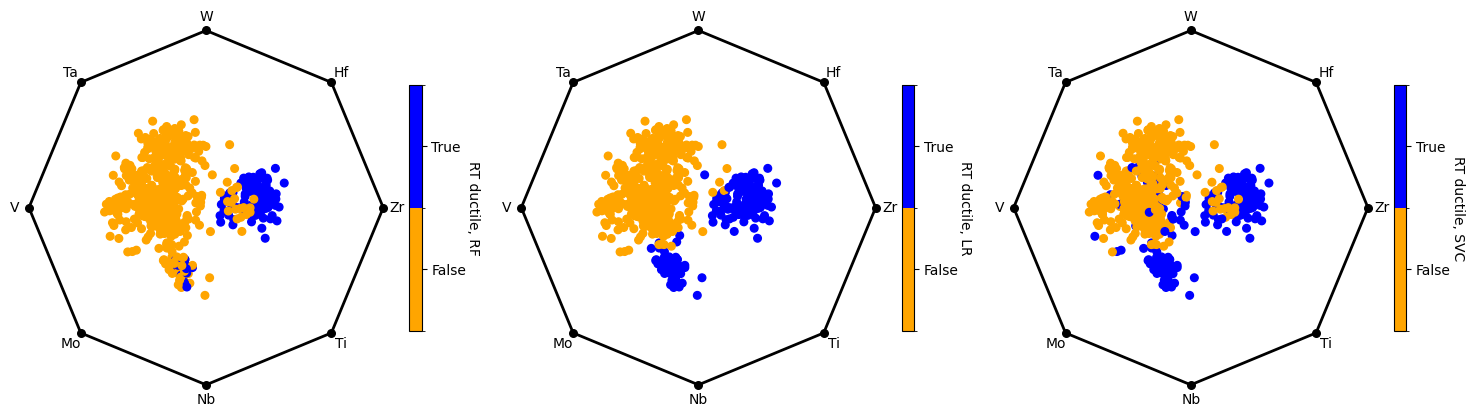

In [ ]:
props = [
    ('rf_prediction', 'RT ductile, RF'),
    ('LR_prediction', 'RT ductile, LR'),
    ('SVC_prediction', 'RT ductile, SVC')
]

n = len(props)
ncols = 3
nrows = (n + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(18, 10))
axes = axes.ravel()

for ax, (col, title) in zip(axes, props):
    plot_affine_map(V, p_list, elements, c_space[col], title, ax=ax)

# turn off unused axes
for ax in axes[n:]:
    ax.axis('off')


plt.show()

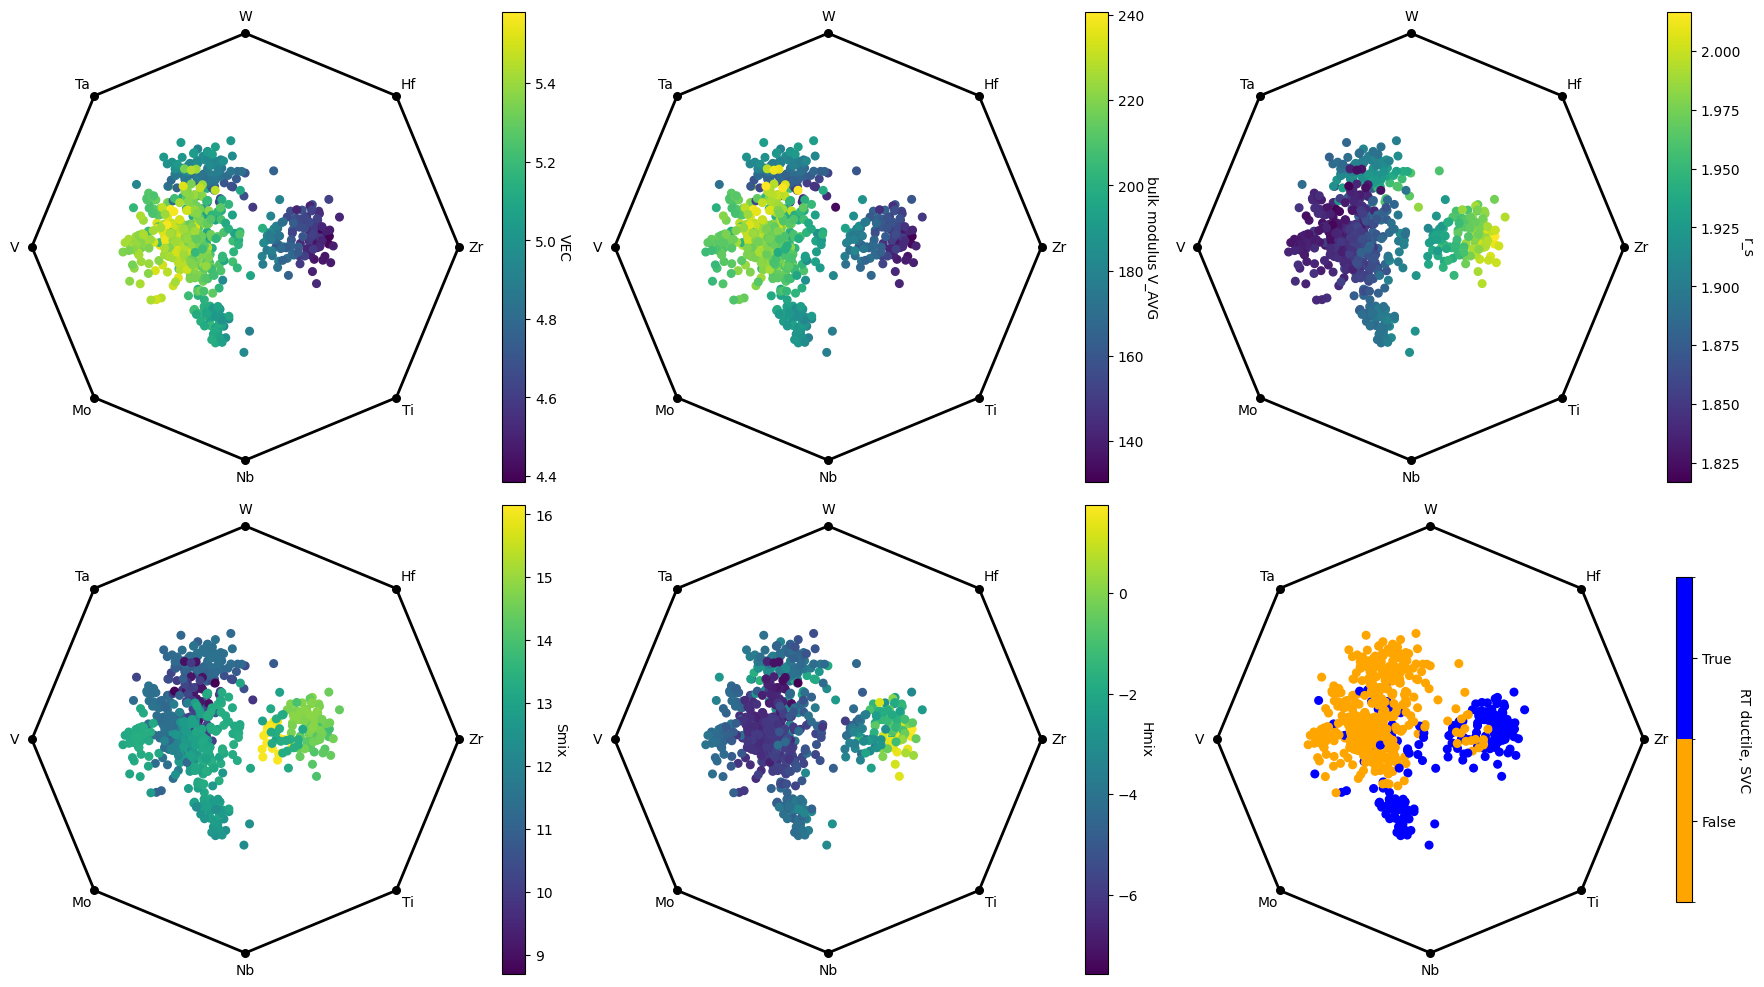

In [ ]:
props = [
    ('VEC', 'VEC'),
    ('bulk modulus V_AVG', 'bulk modulus V_AVG'),
    ('r_s', 'r_s'),
    ('Smix', 'Smix'),
    ('Hmix', 'Hmix'),
    ('SVC_prediction', 'RT ductile, SVC')
]

n = len(props)
ncols = 3
nrows = (n + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(18, 10))
axes = axes.ravel()

for ax, (col, title) in zip(axes, props):
    plot_affine_map(V, p_list, elements, c_space[col], title, ax=ax)

# turn off unused axes
for ax in axes[n:]:
    ax.axis('off')

plt.tight_layout()
plt.show()



<Axes: >

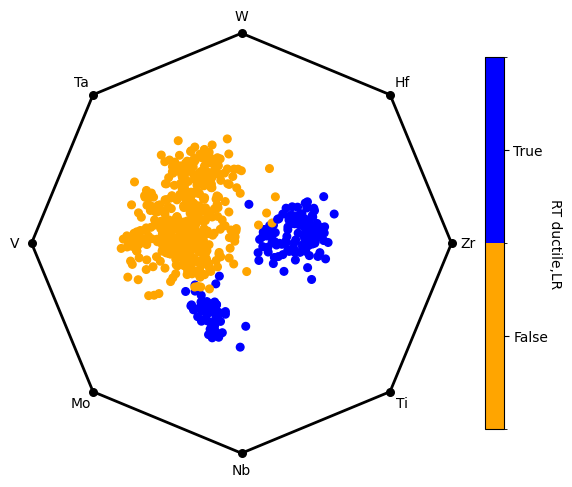

In [ ]:
plot_affine_map(V, points=p_list, labels=elements, prop=c_space['LR_prediction'], z_name='RT ductile,LR')

<Axes: >

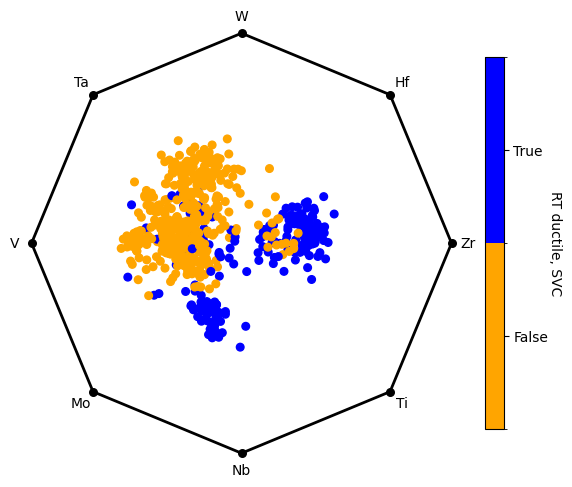

In [ ]:
plot_affine_map(V, points=p_list, labels=elements, prop=c_space['SVC_prediction'], z_name='RT ductile, SVC')

# Solving for Composition Directly

Use the classification models to create distributions of ROM parameters - solve for composition for samples drawn from those distributions

In [ ]:
ROM parameters =

In [ ]:
import numpy as np

def radius_deviation(x, r):
    """
    Atomic size mismatch parameter δ

    x : array of weights (compositions), should sum to 1
    r : array of atomic radii
    """
    x = np.asarray(x)
    r = np.asarray(r)

    rhat = np.dot(x, r)  # weighted mean radius

    # sum of elementwise products
    return np.sqrt(np.sum(x * (1 - r / rhat) ** 2))

In [ ]:
exp_data = pd.read_csv('/content/RT_ROM.csv')

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize, LinearConstraint, Bounds, NonlinearConstraint

element_data = pd.read_csv('/content/total_rom_dataset.csv',index_col=0)
Hmix = pd.read_csv('/content/Hmix.csv',index_col=0)
element_data.drop(['Atomic number'], axis=0, inplace=True)
element_data.drop(['element'], axis=0, inplace=True)
element_data = element_data.astype(float)
element_data.index

Index(['BCC Bulk Modulus', 'r_s', 'rho', 'Atomic radius (pm)',
       'Melting point (K)', 'Boiling point (K)',
       'Pauling electronegativity (-)', 'Allen electronegativity (-)',
       'Valence electron concentration (-)',
       'Itinerant electrons per atom (-)', 'Atomic weight (g/mol)',
       'Density (g/cm3)', 'Molar heat capacity (J/mol K)',
       'Thermal conductivity (W/m/K)', 'shear modulus', 'poissons ratio',
       'youngs modulus', 'bulk modulus'],
      dtype='object')

In [ ]:
def A_matrix(properties, elements, data):
  # Construct the list of property vectors for each element
  matrix_rows = []
  for el in elements:
      element_properties = data.loc[properties, el].to_numpy()
      matrix_rows.append(element_properties)

  # Convert the list of rows to a single NumPy matrix
  A = np.array(matrix_rows)

  # return transposed matrix to get properties in columns
  return A.T

In [ ]:
'''
construction of A matrix and variables for minimize func.
properties = vector of properties to optimize from index of data
A = matrix of properties, columns are an element each
x0 = initial composition vector
lower/upper bounds
'''

properties=['r_s','Melting point (K)']

# get vectors of properties for all of the elements in an alloy
elements = ['Mo', 'Nb', 'Ta', 'W']


bnds = Bounds(0.1, 0.3)

A = A_matrix(properties, elements, element_data)
# check that the matrix has the shape (# of properties, # of elements) so that each column is an element

# set the lower and upper fraction limits of any of the elements you want (i.e.)
#lower_bounds = {'W':0.1,'Nb':0.4}
#upper_bounds = {'Mo':0.3,'Nb':0.45}

# get the number of elements being optimized on
n = A.shape[1]

# initial equiatomic alloy -- can use existing alloy and fewer steps to optimize it (LATER)
x0 = np.ones(n)/n

In [ ]:
data[elements].loc[['shear modulus','bulk modulus']]


,Mo,Nb,Ta,W
shear modulus,20.0,38.0,67.0,161.0
bulk modulus,230.0,170.0,200.0,310.0


In [ ]:
data[elements].loc['shear modulus']/data[elements].loc['bulk modulus']

,0
Mo,0.086957
Nb,0.223529
Ta,0.335000
W,0.519355


In [ ]:
'''
construction of A matrix and variables for minimize func.
properties = vector of properties to optimize from index of data
A = matrix of properties, columns are an element each
b = target vector of properties of interest - optimizes towards that
x0 = initial composition vector
composition = sum to 1
'''

properties=['r_s','Melting point (K)']
b = [1.8, 3230]

# get vectors of properties for all of the elements in an alloy
elements = ['Mo', 'Nb', 'Ta', 'W','Ti','V','Zr']

A = A_matrix(properties, elements, data)
# check that the matrix has the shape (# of properties, # of elements) so that each column is an element

# get the number of elements being optimized on
n = A.shape[1]

# initial equiatomic alloy -- can use existing alloy and fewer steps to optimize it
x0 = np.ones(n)/n


# sum of composition vector has to be 1, and each entry has to be between 0 and 1
composition_constraint = LinearConstraint(np.ones((1,n)), 1.0, 1.0)

#bnds = construct_composition_bounds(lower_bounds,upper_bounds,elements)
bnds = Bounds(0.05, 0.3)


In [ ]:
# objective function is the squared distance between current property vector (Ax) and a target (b)
# minimize objective function given the MC1 and composition constraints

obj = lambda z: np.linalg.norm(A @ z - b)**2
res = minimize(obj, x0, method="SLSQP", constraints=[composition_constraint],
               bounds = bnds,
               options={"ftol":1e-20, "maxiter":10000})
x = res.x

print(f'elements: {elements}')
print(f'composition: {x}')
print(f'total comp: {np.sum(x)}')
print(f'result: {A@x})')
print(f'target: {b}')


/usr/local/lib/python3.12/dist-packages/scipy/optimize/_constraints.py:530: ComplexWarning: Casting complex values to real discards the imaginary part
  y[:n_bound_below] = y_all[i_bound_below] - lb[i_bound_below]
/usr/local/lib/python3.12/dist-packages/scipy/optimize/_constraints.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  y[n_bound_below:] = -(y_all[i_bound_above] - ub[i_bound_above])


elements: ['Mo', 'Nb', 'Ta', 'W', 'Ti', 'V', 'Zr']
composition: [0.27566876 0.05       0.26536876 0.3        0.05       0.05
 0.05      ]
total comp: 1.0410375182705587
result: [1.91020599e+00 3.22999995e+03])
target: [1.8, 3230]


In [ ]:
import json

optimized = res.x
optimized = optimized*100

output = {el: val for el, val in zip(elements, optimized)}

with open('optimized.json', 'w') as f:
    json.dump(output, f)